# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 24139 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)


  0% (    1 of 24139) |             | Elapsed Time: 0:00:04 ETA:  1 day, 8:57:13

  0% (   65 of 24139) |                    | Elapsed Time: 0:00:05 ETA:  0:06:13

  0% (  142 of 24139) |                    | Elapsed Time: 0:00:06 ETA:  0:05:38

  0% (  212 of 24139) |                    | Elapsed Time: 0:00:07 ETA:  0:05:38

  1% (  263 of 24139) |                    | Elapsed Time: 0:00:08 ETA:  0:06:02

  1% (  302 of 24139) |                    | Elapsed Time: 0:00:09 ETA:  0:05:59

  1% (  364 of 24139) |                    | Elapsed Time: 0:00:10 ETA:  0:06:02

  1% (  431 of 24139) |                    | Elapsed Time: 0:00:11 ETA:  0:06:00

  2% (  502 of 24139) |                    | Elapsed Time: 0:00:12 ETA:  0:05:54

  2% (  574 of 24139) |                    | Elapsed Time: 0:00:13 ETA:  0:05:49

  2% (  604 of 24139) |                    | Elapsed Time: 0:00:13 ETA:  0:05:47

  2% (  677 of 24139) |                    | Elapsed Time: 0:00:14 ETA:  0:05:48

  3% (  748 of 24139) |                    | Elapsed Time: 0:00:16 ETA:  0:05:47

  3% (  821 of 24139) |                    | Elapsed Time: 0:00:17 ETA:  0:05:31

  3% (  884 of 24139) |                    | Elapsed Time: 0:00:18 ETA:  0:05:34

  3% (  906 of 24139) |                    | Elapsed Time: 0:00:18 ETA:  0:05:29

  4% (  975 of 24139) |                    | Elapsed Time: 0:00:19 ETA:  0:05:27

  4% ( 1043 of 24139) |                    | Elapsed Time: 0:00:20 ETA:  0:05:42

  4% ( 1115 of 24139) |                    | Elapsed Time: 0:00:21 ETA:  0:05:41

  4% ( 1180 of 24139) |                    | Elapsed Time: 0:00:22 ETA:  0:05:41

  5% ( 1207 of 24139) |#                   | Elapsed Time: 0:00:23 ETA:  0:05:48

  5% ( 1281 of 24139) |#                   | Elapsed Time: 0:00:24 ETA:  0:05:45

  5% ( 1346 of 24139) |#                   | Elapsed Time: 0:00:25 ETA:  0:05:50

  5% ( 1410 of 24139) |#                   | Elapsed Time: 0:00:26 ETA:  0:05:48

  6% ( 1486 of 24139) |#                   | Elapsed Time: 0:00:27 ETA:  0:05:41

  6% ( 1509 of 24139) |#                   | Elapsed Time: 0:00:27 ETA:  0:05:41

  6% ( 1588 of 24139) |#                   | Elapsed Time: 0:00:28 ETA:  0:05:18

  6% ( 1658 of 24139) |#                   | Elapsed Time: 0:00:29 ETA:  0:05:18

  7% ( 1725 of 24139) |#                   | Elapsed Time: 0:00:30 ETA:  0:05:16

  7% ( 1792 of 24139) |#                   | Elapsed Time: 0:00:31 ETA:  0:05:13

  7% ( 1811 of 24139) |#                   | Elapsed Time: 0:00:31 ETA:  0:05:16

  7% ( 1877 of 24139) |#                   | Elapsed Time: 0:00:32 ETA:  0:05:15

  8% ( 1948 of 24139) |#                   | Elapsed Time: 0:00:33 ETA:  0:05:10

  8% ( 2010 of 24139) |#                   | Elapsed Time: 0:00:34 ETA:  0:05:18

  8% ( 2066 of 24139) |#                   | Elapsed Time: 0:00:35 ETA:  0:05:26

  8% ( 2113 of 24139) |#                   | Elapsed Time: 0:00:36 ETA:  0:05:32

  9% ( 2180 of 24139) |#                   | Elapsed Time: 0:00:37 ETA:  0:05:33

  9% ( 2240 of 24139) |#                   | Elapsed Time: 0:00:38 ETA:  0:05:37

  9% ( 2310 of 24139) |#                   | Elapsed Time: 0:00:39 ETA:  0:05:33

  9% ( 2383 of 24139) |#                   | Elapsed Time: 0:00:40 ETA:  0:05:27

 10% ( 2414 of 24139) |##                  | Elapsed Time: 0:00:41 ETA:  0:05:28

 10% ( 2467 of 24139) |##                  | Elapsed Time: 0:00:42 ETA:  0:05:40

 10% ( 2538 of 24139) |##                  | Elapsed Time: 0:00:43 ETA:  0:05:31

 10% ( 2608 of 24139) |##                  | Elapsed Time: 0:00:44 ETA:  0:05:21

 11% ( 2663 of 24139) |##                  | Elapsed Time: 0:00:45 ETA:  0:05:41

 11% ( 2716 of 24139) |##                  | Elapsed Time: 0:00:46 ETA:  0:05:38

 11% ( 2787 of 24139) |##                  | Elapsed Time: 0:00:47 ETA:  0:05:30

 11% ( 2859 of 24139) |##                  | Elapsed Time: 0:00:48 ETA:  0:05:27

 12% ( 2926 of 24139) |##                  | Elapsed Time: 0:00:49 ETA:  0:05:31

 12% ( 2990 of 24139) |##                  | Elapsed Time: 0:00:50 ETA:  0:05:29

 12% ( 3018 of 24139) |##                  | Elapsed Time: 0:00:50 ETA:  0:05:20

 12% ( 3066 of 24139) |##                  | Elapsed Time: 0:00:51 ETA:  0:05:35

 12% ( 3135 of 24139) |##                  | Elapsed Time: 0:00:52 ETA:  0:05:35

 13% ( 3208 of 24139) |##                  | Elapsed Time: 0:00:53 ETA:  0:05:09

 13% ( 3277 of 24139) |##                  | Elapsed Time: 0:00:54 ETA:  0:05:10

 13% ( 3320 of 24139) |##                  | Elapsed Time: 0:00:55 ETA:  0:05:08

 14% ( 3385 of 24139) |##                  | Elapsed Time: 0:00:56 ETA:  0:05:12

 14% ( 3455 of 24139) |##                  | Elapsed Time: 0:00:57 ETA:  0:05:09

 14% ( 3521 of 24139) |##                  | Elapsed Time: 0:00:58 ETA:  0:05:06

 14% ( 3583 of 24139) |##                  | Elapsed Time: 0:00:59 ETA:  0:05:09

 15% ( 3621 of 24139) |###                 | Elapsed Time: 0:00:59 ETA:  0:04:54

 15% ( 3698 of 24139) |###                 | Elapsed Time: 0:01:00 ETA:  0:04:48

 15% ( 3770 of 24139) |###                 | Elapsed Time: 0:01:01 ETA:  0:04:48

 15% ( 3845 of 24139) |###                 | Elapsed Time: 0:01:02 ETA:  0:04:43

 16% ( 3923 of 24139) |###                 | Elapsed Time: 0:01:03 ETA:  0:04:42

 16% ( 3985 of 24139) |###                 | Elapsed Time: 0:01:04 ETA:  0:04:46

 16% ( 4050 of 24139) |###                 | Elapsed Time: 0:01:05 ETA:  0:04:46

 17% ( 4119 of 24139) |###                 | Elapsed Time: 0:01:06 ETA:  0:04:41

 17% ( 4166 of 24139) |###                 | Elapsed Time: 0:01:07 ETA:  0:04:56

 17% ( 4225 of 24139) |###                 | Elapsed Time: 0:01:08 ETA:  0:05:04

 17% ( 4288 of 24139) |###                 | Elapsed Time: 0:01:09 ETA:  0:05:10

 17% ( 4344 of 24139) |###                 | Elapsed Time: 0:01:10 ETA:  0:05:23

 18% ( 4402 of 24139) |###                 | Elapsed Time: 0:01:11 ETA:  0:05:30

 18% ( 4462 of 24139) |###                 | Elapsed Time: 0:01:12 ETA:  0:05:30

 18% ( 4527 of 24139) |###                 | Elapsed Time: 0:01:13 ETA:  0:05:22

 19% ( 4601 of 24139) |###                 | Elapsed Time: 0:01:14 ETA:  0:05:14

 19% ( 4674 of 24139) |###                 | Elapsed Time: 0:01:15 ETA:  0:05:10

 19% ( 4749 of 24139) |###                 | Elapsed Time: 0:01:16 ETA:  0:04:50

 20% ( 4828 of 24139) |####                | Elapsed Time: 0:01:17 ETA:  0:04:40

 20% ( 4860 of 24139) |####                | Elapsed Time: 0:01:18 ETA:  0:04:59

 20% ( 4932 of 24139) |####                | Elapsed Time: 0:01:19 ETA:  0:04:49

 20% ( 5011 of 24139) |####                | Elapsed Time: 0:01:20 ETA:  0:04:35

 21% ( 5081 of 24139) |####                | Elapsed Time: 0:01:21 ETA:  0:04:35

 21% ( 5130 of 24139) |####                | Elapsed Time: 0:01:22 ETA:  0:04:37

 21% ( 5189 of 24139) |####                | Elapsed Time: 0:01:23 ETA:  0:04:46

 21% ( 5258 of 24139) |####                | Elapsed Time: 0:01:24 ETA:  0:04:49

 22% ( 5329 of 24139) |####                | Elapsed Time: 0:01:25 ETA:  0:04:50

 22% ( 5398 of 24139) |####                | Elapsed Time: 0:01:26 ETA:  0:04:46

 22% ( 5432 of 24139) |####                | Elapsed Time: 0:01:27 ETA:  0:04:18

 22% ( 5508 of 24139) |####                | Elapsed Time: 0:01:28 ETA:  0:04:15

 23% ( 5584 of 24139) |####                | Elapsed Time: 0:01:29 ETA:  0:04:16

 23% ( 5659 of 24139) |####                | Elapsed Time: 0:01:30 ETA:  0:04:12

 23% ( 5734 of 24139) |####                | Elapsed Time: 0:01:31 ETA:  0:04:09

 24% ( 5804 of 24139) |####                | Elapsed Time: 0:01:32 ETA:  0:04:02

 24% ( 5881 of 24139) |####                | Elapsed Time: 0:01:33 ETA:  0:03:56

 24% ( 5954 of 24139) |####                | Elapsed Time: 0:01:34 ETA:  0:03:54

 24% ( 6019 of 24139) |####                | Elapsed Time: 0:01:35 ETA:  0:03:55

 25% ( 6035 of 24139) |#####               | Elapsed Time: 0:01:35 ETA:  0:03:56

 25% ( 6107 of 24139) |#####               | Elapsed Time: 0:01:36 ETA:  0:03:57

 25% ( 6186 of 24139) |#####               | Elapsed Time: 0:01:37 ETA:  0:03:54

 25% ( 6262 of 24139) |#####               | Elapsed Time: 0:01:38 ETA:  0:03:53

 26% ( 6337 of 24139) |#####               | Elapsed Time: 0:01:39 ETA:  0:03:50

 26% ( 6408 of 24139) |#####               | Elapsed Time: 0:01:40 ETA:  0:03:52

 26% ( 6476 of 24139) |#####               | Elapsed Time: 0:01:41 ETA:  0:03:55

 27% ( 6546 of 24139) |#####               | Elapsed Time: 0:01:42 ETA:  0:03:50

 27% ( 6622 of 24139) |#####               | Elapsed Time: 0:01:43 ETA:  0:03:47

 27% ( 6639 of 24139) |#####               | Elapsed Time: 0:01:43 ETA:  0:03:45

 27% ( 6712 of 24139) |#####               | Elapsed Time: 0:01:44 ETA:  0:03:47

 28% ( 6774 of 24139) |#####               | Elapsed Time: 0:01:45 ETA:  0:03:56

 28% ( 6834 of 24139) |#####               | Elapsed Time: 0:01:46 ETA:  0:04:05

 28% ( 6907 of 24139) |#####               | Elapsed Time: 0:01:47 ETA:  0:04:01

 28% ( 6940 of 24139) |#####               | Elapsed Time: 0:01:48 ETA:  0:04:01

 29% ( 7015 of 24139) |#####               | Elapsed Time: 0:01:49 ETA:  0:03:56

 29% ( 7087 of 24139) |#####               | Elapsed Time: 0:01:50 ETA:  0:03:54

 29% ( 7162 of 24139) |#####               | Elapsed Time: 0:01:51 ETA:  0:03:54

 30% ( 7242 of 24139) |######              | Elapsed Time: 0:01:52 ETA:  0:03:52

 30% ( 7313 of 24139) |######              | Elapsed Time: 0:01:53 ETA:  0:03:45

 30% ( 7380 of 24139) |######              | Elapsed Time: 0:01:54 ETA:  0:03:40

 30% ( 7454 of 24139) |######              | Elapsed Time: 0:01:55 ETA:  0:03:38

 31% ( 7528 of 24139) |######              | Elapsed Time: 0:01:56 ETA:  0:03:37

 31% ( 7544 of 24139) |######              | Elapsed Time: 0:01:56 ETA:  0:03:37

 31% ( 7613 of 24139) |######              | Elapsed Time: 0:01:57 ETA:  0:03:37

 31% ( 7680 of 24139) |######              | Elapsed Time: 0:01:58 ETA:  0:03:42

 32% ( 7758 of 24139) |######              | Elapsed Time: 0:01:59 ETA:  0:03:40

 32% ( 7846 of 24139) |######              | Elapsed Time: 0:02:00 ETA:  0:03:33

 32% ( 7918 of 24139) |######              | Elapsed Time: 0:02:02 ETA:  0:03:59

 33% ( 7990 of 24139) |######              | Elapsed Time: 0:02:03 ETA:  0:04:00

 33% ( 8065 of 24139) |######              | Elapsed Time: 0:02:04 ETA:  0:03:58

 33% ( 8147 of 24139) |######              | Elapsed Time: 0:02:05 ETA:  0:03:56

 34% ( 8228 of 24139) |######              | Elapsed Time: 0:02:06 ETA:  0:03:46

 34% ( 8306 of 24139) |######              | Elapsed Time: 0:02:07 ETA:  0:03:45

 34% ( 8383 of 24139) |######              | Elapsed Time: 0:02:08 ETA:  0:03:44

 35% ( 8449 of 24139) |#######             | Elapsed Time: 0:02:09 ETA:  0:03:40

 35% ( 8518 of 24139) |#######             | Elapsed Time: 0:02:10 ETA:  0:03:13

 35% ( 8593 of 24139) |#######             | Elapsed Time: 0:02:11 ETA:  0:03:11

 35% ( 8664 of 24139) |#######             | Elapsed Time: 0:02:12 ETA:  0:03:13

 36% ( 8751 of 24139) |#######             | Elapsed Time: 0:02:13 ETA:  0:03:06

 36% ( 8834 of 24139) |#######             | Elapsed Time: 0:02:14 ETA:  0:03:04

 36% ( 8911 of 24139) |#######             | Elapsed Time: 0:02:15 ETA:  0:03:03

 37% ( 8986 of 24139) |#######             | Elapsed Time: 0:02:16 ETA:  0:03:03

 37% ( 9053 of 24139) |#######             | Elapsed Time: 0:02:17 ETA:  0:03:02

 37% ( 9133 of 24139) |#######             | Elapsed Time: 0:02:18 ETA:  0:02:55

 38% ( 9211 of 24139) |#######             | Elapsed Time: 0:02:19 ETA:  0:02:52

 38% ( 9291 of 24139) |#######             | Elapsed Time: 0:02:20 ETA:  0:02:46

 38% ( 9354 of 24139) |#######             | Elapsed Time: 0:02:21 ETA:  0:02:55

 39% ( 9418 of 24139) |#######             | Elapsed Time: 0:02:22 ETA:  0:02:59

 39% ( 9495 of 24139) |#######             | Elapsed Time: 0:02:23 ETA:  0:03:02

 39% ( 9572 of 24139) |#######             | Elapsed Time: 0:02:24 ETA:  0:03:01

 39% ( 9639 of 24139) |#######             | Elapsed Time: 0:02:25 ETA:  0:03:03

 40% ( 9656 of 24139) |########            | Elapsed Time: 0:02:25 ETA:  0:03:06

 40% ( 9733 of 24139) |########            | Elapsed Time: 0:02:26 ETA:  0:03:06

 40% ( 9811 of 24139) |########            | Elapsed Time: 0:02:27 ETA:  0:03:05

 40% ( 9878 of 24139) |########            | Elapsed Time: 0:02:28 ETA:  0:03:12

 41% ( 9958 of 24139) |########            | Elapsed Time: 0:02:29 ETA:  0:02:57

 41% (10031 of 24139) |########            | Elapsed Time: 0:02:30 ETA:  0:02:58

 41% (10105 of 24139) |########            | Elapsed Time: 0:02:31 ETA:  0:02:58

 42% (10182 of 24139) |########            | Elapsed Time: 0:02:32 ETA:  0:02:51

 42% (10260 of 24139) |########            | Elapsed Time: 0:02:33 ETA:  0:02:57

 42% (10329 of 24139) |########            | Elapsed Time: 0:02:34 ETA:  0:03:02

 43% (10393 of 24139) |########            | Elapsed Time: 0:02:35 ETA:  0:03:03

 43% (10462 of 24139) |########            | Elapsed Time: 0:02:36 ETA:  0:03:09

 43% (10535 of 24139) |########            | Elapsed Time: 0:02:37 ETA:  0:03:06

 43% (10561 of 24139) |########            | Elapsed Time: 0:02:38 ETA:  0:03:11

 44% (10627 of 24139) |########            | Elapsed Time: 0:02:39 ETA:  0:03:16

 44% (10698 of 24139) |########            | Elapsed Time: 0:02:40 ETA:  0:03:19

 44% (10773 of 24139) |########            | Elapsed Time: 0:02:41 ETA:  0:03:10

 44% (10838 of 24139) |########            | Elapsed Time: 0:02:42 ETA:  0:03:13

 45% (10863 of 24139) |#########           | Elapsed Time: 0:02:42 ETA:  0:03:11

 45% (10927 of 24139) |#########           | Elapsed Time: 0:02:43 ETA:  0:03:10

 45% (11002 of 24139) |#########           | Elapsed Time: 0:02:44 ETA:  0:03:05

 45% (11072 of 24139) |#########           | Elapsed Time: 0:02:45 ETA:  0:03:05

 46% (11135 of 24139) |#########           | Elapsed Time: 0:02:46 ETA:  0:03:05

 46% (11165 of 24139) |#########           | Elapsed Time: 0:02:47 ETA:  0:03:09

 46% (11238 of 24139) |#########           | Elapsed Time: 0:02:48 ETA:  0:03:06

 46% (11313 of 24139) |#########           | Elapsed Time: 0:02:49 ETA:  0:03:05

 47% (11384 of 24139) |#########           | Elapsed Time: 0:02:50 ETA:  0:03:00

 47% (11467 of 24139) |#########           | Elapsed Time: 0:02:51 ETA:  0:02:53

 47% (11543 of 24139) |#########           | Elapsed Time: 0:02:52 ETA:  0:02:51

 48% (11618 of 24139) |#########           | Elapsed Time: 0:02:53 ETA:  0:02:47

 48% (11690 of 24139) |#########           | Elapsed Time: 0:02:54 ETA:  0:02:41

 48% (11742 of 24139) |#########           | Elapsed Time: 0:02:56 ETA:  0:03:07

 48% (11768 of 24139) |#########           | Elapsed Time: 0:02:56 ETA:  0:03:09

 49% (11835 of 24139) |#########           | Elapsed Time: 0:02:57 ETA:  0:03:14

 49% (11905 of 24139) |#########           | Elapsed Time: 0:02:58 ETA:  0:03:14

 49% (11976 of 24139) |#########           | Elapsed Time: 0:02:59 ETA:  0:03:16

 49% (12045 of 24139) |#########           | Elapsed Time: 0:03:00 ETA:  0:03:13

 50% (12070 of 24139) |##########          | Elapsed Time: 0:03:00 ETA:  0:03:23

 50% (12139 of 24139) |##########          | Elapsed Time: 0:03:01 ETA:  0:03:27

 50% (12203 of 24139) |##########          | Elapsed Time: 0:03:02 ETA:  0:03:32

 50% (12277 of 24139) |##########          | Elapsed Time: 0:03:03 ETA:  0:02:50

 51% (12350 of 24139) |##########          | Elapsed Time: 0:03:04 ETA:  0:02:48

 51% (12372 of 24139) |##########          | Elapsed Time: 0:03:05 ETA:  0:02:46

 51% (12448 of 24139) |##########          | Elapsed Time: 0:03:06 ETA:  0:02:41

 51% (12528 of 24139) |##########          | Elapsed Time: 0:03:07 ETA:  0:02:34

 52% (12600 of 24139) |##########          | Elapsed Time: 0:03:08 ETA:  0:02:32

 52% (12673 of 24139) |##########          | Elapsed Time: 0:03:09 ETA:  0:02:25

 52% (12739 of 24139) |##########          | Elapsed Time: 0:03:10 ETA:  0:02:23

 53% (12810 of 24139) |##########          | Elapsed Time: 0:03:11 ETA:  0:02:24

 53% (12880 of 24139) |##########          | Elapsed Time: 0:03:12 ETA:  0:02:25

 53% (12952 of 24139) |##########          | Elapsed Time: 0:03:13 ETA:  0:02:23

 53% (12975 of 24139) |##########          | Elapsed Time: 0:03:13 ETA:  0:02:26

 54% (13049 of 24139) |##########          | Elapsed Time: 0:03:14 ETA:  0:02:29

 54% (13121 of 24139) |##########          | Elapsed Time: 0:03:15 ETA:  0:02:28

 54% (13198 of 24139) |##########          | Elapsed Time: 0:03:16 ETA:  0:02:24

 55% (13277 of 24139) |###########         | Elapsed Time: 0:03:17 ETA:  0:02:17

 55% (13350 of 24139) |###########         | Elapsed Time: 0:03:18 ETA:  0:02:15

 55% (13422 of 24139) |###########         | Elapsed Time: 0:03:19 ETA:  0:02:12

 55% (13499 of 24139) |###########         | Elapsed Time: 0:03:20 ETA:  0:02:08

 56% (13579 of 24139) |###########         | Elapsed Time: 0:03:21 ETA:  0:02:07

 56% (13657 of 24139) |###########         | Elapsed Time: 0:03:22 ETA:  0:02:02

 56% (13731 of 24139) |###########         | Elapsed Time: 0:03:23 ETA:  0:02:02

 57% (13809 of 24139) |###########         | Elapsed Time: 0:03:24 ETA:  0:01:59

 57% (13880 of 24139) |###########         | Elapsed Time: 0:03:25 ETA:  0:01:57

 57% (13947 of 24139) |###########         | Elapsed Time: 0:03:26 ETA:  0:02:00

 58% (14022 of 24139) |###########         | Elapsed Time: 0:03:27 ETA:  0:01:57

 58% (14098 of 24139) |###########         | Elapsed Time: 0:03:28 ETA:  0:01:58

 58% (14182 of 24139) |###########         | Elapsed Time: 0:03:30 ETA:  0:01:57

 59% (14260 of 24139) |###########         | Elapsed Time: 0:03:31 ETA:  0:01:55

 59% (14341 of 24139) |###########         | Elapsed Time: 0:03:32 ETA:  0:01:51

 59% (14410 of 24139) |###########         | Elapsed Time: 0:03:33 ETA:  0:01:55

 60% (14484 of 24139) |############        | Elapsed Time: 0:03:34 ETA:  0:01:54

 60% (14563 of 24139) |############        | Elapsed Time: 0:03:35 ETA:  0:01:51

 60% (14635 of 24139) |############        | Elapsed Time: 0:03:36 ETA:  0:01:51

 60% (14694 of 24139) |############        | Elapsed Time: 0:03:37 ETA:  0:01:57

 61% (14763 of 24139) |############        | Elapsed Time: 0:03:38 ETA:  0:01:59

 61% (14786 of 24139) |############        | Elapsed Time: 0:03:38 ETA:  0:02:04

 61% (14855 of 24139) |############        | Elapsed Time: 0:03:39 ETA:  0:02:11

 61% (14925 of 24139) |############        | Elapsed Time: 0:03:40 ETA:  0:02:10

 62% (14990 of 24139) |############        | Elapsed Time: 0:03:41 ETA:  0:02:11

 62% (15066 of 24139) |############        | Elapsed Time: 0:03:42 ETA:  0:02:05

 62% (15087 of 24139) |############        | Elapsed Time: 0:03:42 ETA:  0:02:10

 62% (15162 of 24139) |############        | Elapsed Time: 0:03:43 ETA:  0:02:07

 63% (15236 of 24139) |############        | Elapsed Time: 0:03:44 ETA:  0:01:56

 63% (15309 of 24139) |############        | Elapsed Time: 0:03:45 ETA:  0:01:53

 63% (15389 of 24139) |############        | Elapsed Time: 0:03:46 ETA:  0:01:45

 64% (15453 of 24139) |############        | Elapsed Time: 0:03:47 ETA:  0:01:47

 64% (15514 of 24139) |############        | Elapsed Time: 0:03:48 ETA:  0:01:49

 64% (15584 of 24139) |############        | Elapsed Time: 0:03:49 ETA:  0:01:52

 64% (15658 of 24139) |############        | Elapsed Time: 0:03:50 ETA:  0:01:50

 65% (15691 of 24139) |#############       | Elapsed Time: 0:03:51 ETA:  0:01:52

 65% (15763 of 24139) |#############       | Elapsed Time: 0:03:52 ETA:  0:01:53

 65% (15835 of 24139) |#############       | Elapsed Time: 0:03:53 ETA:  0:01:53

 65% (15907 of 24139) |#############       | Elapsed Time: 0:03:54 ETA:  0:01:55

 66% (15993 of 24139) |#############       | Elapsed Time: 0:03:55 ETA:  0:01:45

 66% (16067 of 24139) |#############       | Elapsed Time: 0:03:56 ETA:  0:01:35

 66% (16144 of 24139) |#############       | Elapsed Time: 0:03:57 ETA:  0:01:31

 67% (16220 of 24139) |#############       | Elapsed Time: 0:03:58 ETA:  0:01:29

 67% (16294 of 24139) |#############       | Elapsed Time: 0:03:59 ETA:  0:01:27

 67% (16362 of 24139) |#############       | Elapsed Time: 0:04:01 ETA:  0:02:03

 68% (16418 of 24139) |#############       | Elapsed Time: 0:04:02 ETA:  0:02:12

 68% (16490 of 24139) |#############       | Elapsed Time: 0:04:03 ETA:  0:02:11

 68% (16560 of 24139) |#############       | Elapsed Time: 0:04:04 ETA:  0:02:14

 68% (16596 of 24139) |#############       | Elapsed Time: 0:04:05 ETA:  0:02:13

 69% (16666 of 24139) |#############       | Elapsed Time: 0:04:06 ETA:  0:02:15

 69% (16743 of 24139) |#############       | Elapsed Time: 0:04:07 ETA:  0:02:13

 69% (16793 of 24139) |#############       | Elapsed Time: 0:04:08 ETA:  0:02:29

 69% (16869 of 24139) |#############       | Elapsed Time: 0:04:09 ETA:  0:02:27

 70% (16898 of 24139) |##############      | Elapsed Time: 0:04:09 ETA:  0:01:48

 70% (16970 of 24139) |##############      | Elapsed Time: 0:04:10 ETA:  0:01:37

 70% (17052 of 24139) |##############      | Elapsed Time: 0:04:11 ETA:  0:01:30

 70% (17121 of 24139) |##############      | Elapsed Time: 0:04:12 ETA:  0:01:30

 71% (17191 of 24139) |##############      | Elapsed Time: 0:04:13 ETA:  0:01:29

 71% (17200 of 24139) |##############      | Elapsed Time: 0:04:13 ETA:  0:01:33

 71% (17267 of 24139) |##############      | Elapsed Time: 0:04:14 ETA:  0:01:39

 71% (17340 of 24139) |##############      | Elapsed Time: 0:04:15 ETA:  0:01:23

 72% (17415 of 24139) |##############      | Elapsed Time: 0:04:16 ETA:  0:01:23

 72% (17501 of 24139) |##############      | Elapsed Time: 0:04:17 ETA:  0:01:20

 72% (17582 of 24139) |##############      | Elapsed Time: 0:04:18 ETA:  0:01:19

 73% (17655 of 24139) |##############      | Elapsed Time: 0:04:19 ETA:  0:01:16

 73% (17729 of 24139) |##############      | Elapsed Time: 0:04:20 ETA:  0:01:12

 73% (17803 of 24139) |##############      | Elapsed Time: 0:04:22 ETA:  0:01:06

 74% (17873 of 24139) |##############      | Elapsed Time: 0:04:23 ETA:  0:01:07

 74% (17949 of 24139) |##############      | Elapsed Time: 0:04:24 ETA:  0:01:05

 74% (18023 of 24139) |##############      | Elapsed Time: 0:04:25 ETA:  0:01:05

 75% (18105 of 24139) |###############     | Elapsed Time: 0:04:26 ETA:  0:01:08

 75% (18183 of 24139) |###############     | Elapsed Time: 0:04:27 ETA:  0:01:03

 75% (18265 of 24139) |###############     | Elapsed Time: 0:04:28 ETA:  0:00:57

 75% (18340 of 24139) |###############     | Elapsed Time: 0:04:29 ETA:  0:00:51

 76% (18406 of 24139) |###############     | Elapsed Time: 0:04:30 ETA:  0:00:53

 76% (18477 of 24139) |###############     | Elapsed Time: 0:04:31 ETA:  0:00:52

 76% (18546 of 24139) |###############     | Elapsed Time: 0:04:32 ETA:  0:00:55

 77% (18622 of 24139) |###############     | Elapsed Time: 0:04:33 ETA:  0:00:53

 77% (18708 of 24139) |###############     | Elapsed Time: 0:04:34 ETA:  0:00:49

 77% (18784 of 24139) |###############     | Elapsed Time: 0:04:35 ETA:  0:00:49

 78% (18856 of 24139) |###############     | Elapsed Time: 0:04:36 ETA:  0:00:54

 78% (18929 of 24139) |###############     | Elapsed Time: 0:04:37 ETA:  0:00:54

 78% (19010 of 24139) |###############     | Elapsed Time: 0:04:38 ETA:  0:00:48

 79% (19085 of 24139) |###############     | Elapsed Time: 0:04:39 ETA:  0:00:43

 79% (19163 of 24139) |###############     | Elapsed Time: 0:04:40 ETA:  0:00:41

 79% (19237 of 24139) |###############     | Elapsed Time: 0:04:41 ETA:  0:00:43

 80% (19312 of 24139) |################    | Elapsed Time: 0:04:42 ETA:  0:00:45

 80% (19387 of 24139) |################    | Elapsed Time: 0:04:43 ETA:  0:00:42

 80% (19452 of 24139) |################    | Elapsed Time: 0:04:44 ETA:  0:00:46

 80% (19521 of 24139) |################    | Elapsed Time: 0:04:45 ETA:  0:00:48

 81% (19598 of 24139) |################    | Elapsed Time: 0:04:46 ETA:  0:00:45

 81% (19613 of 24139) |################    | Elapsed Time: 0:04:46 ETA:  0:00:47

 81% (19679 of 24139) |################    | Elapsed Time: 0:04:47 ETA:  0:00:53

 81% (19749 of 24139) |################    | Elapsed Time: 0:04:48 ETA:  0:00:55

 82% (19815 of 24139) |################    | Elapsed Time: 0:04:49 ETA:  0:00:58

 82% (19887 of 24139) |################    | Elapsed Time: 0:04:50 ETA:  0:00:56

 82% (19915 of 24139) |################    | Elapsed Time: 0:04:51 ETA:  0:00:58

 82% (19984 of 24139) |################    | Elapsed Time: 0:04:52 ETA:  0:00:55

 83% (20057 of 24139) |################    | Elapsed Time: 0:04:53 ETA:  0:00:52

 83% (20134 of 24139) |################    | Elapsed Time: 0:04:54 ETA:  0:00:51

 83% (20196 of 24139) |################    | Elapsed Time: 0:04:55 ETA:  0:00:54

 83% (20217 of 24139) |################    | Elapsed Time: 0:04:55 ETA:  0:00:52

 84% (20287 of 24139) |################    | Elapsed Time: 0:04:56 ETA:  0:00:50

 84% (20360 of 24139) |################    | Elapsed Time: 0:04:57 ETA:  0:00:45

 84% (20436 of 24139) |################    | Elapsed Time: 0:04:58 ETA:  0:00:41

 85% (20519 of 24139) |#################   | Elapsed Time: 0:04:59 ETA:  0:00:33

 85% (20592 of 24139) |#################   | Elapsed Time: 0:05:00 ETA:  0:00:32

 85% (20669 of 24139) |#################   | Elapsed Time: 0:05:01 ETA:  0:00:31

 85% (20745 of 24139) |#################   | Elapsed Time: 0:05:02 ETA:  0:00:22

 86% (20820 of 24139) |#################   | Elapsed Time: 0:05:03 ETA:  0:00:19

 86% (20891 of 24139) |#################   | Elapsed Time: 0:05:04 ETA:  0:00:18

 86% (20960 of 24139) |#################   | Elapsed Time: 0:05:05 ETA:  0:00:19

 87% (21024 of 24139) |#################   | Elapsed Time: 0:05:06 ETA:  0:00:25

 87% (21102 of 24139) |#################   | Elapsed Time: 0:05:07 ETA:  0:00:25

 87% (21122 of 24139) |#################   | Elapsed Time: 0:05:07 ETA:  0:00:24

 87% (21198 of 24139) |#################   | Elapsed Time: 0:05:08 ETA:  0:00:21

 88% (21268 of 24139) |#################   | Elapsed Time: 0:05:09 ETA:  0:00:24

 88% (21337 of 24139) |#################   | Elapsed Time: 0:05:10 ETA:  0:00:27

 88% (21390 of 24139) |#################   | Elapsed Time: 0:05:11 ETA:  0:00:39

 88% (21424 of 24139) |#################   | Elapsed Time: 0:05:12 ETA:  0:00:38

 89% (21503 of 24139) |#################   | Elapsed Time: 0:05:13 ETA:  0:00:30

 89% (21581 of 24139) |#################   | Elapsed Time: 0:05:14 ETA:  0:00:20

 89% (21656 of 24139) |#################   | Elapsed Time: 0:05:15 ETA:  0:00:21

 90% (21726 of 24139) |##################  | Elapsed Time: 0:05:16 ETA:  0:00:19

 90% (21799 of 24139) |##################  | Elapsed Time: 0:05:17 ETA:  0:00:20

 90% (21877 of 24139) |##################  | Elapsed Time: 0:05:18 ETA:  0:00:15

 90% (21951 of 24139) |##################  | Elapsed Time: 0:05:19 ETA:  0:00:11

 91% (22027 of 24139) |##################  | Elapsed Time: 0:05:20 ETA:  0:00:04

 91% (22074 of 24139) |##################  | Elapsed Time: 0:05:22 ETA:  0:01:01

 91% (22143 of 24139) |##################  | Elapsed Time: 0:05:23 ETA:  0:01:06

 92% (22211 of 24139) |##################  | Elapsed Time: 0:05:24 ETA:  0:01:10

 92% (22282 of 24139) |##################  | Elapsed Time: 0:05:25 ETA:  0:01:11

 92% (22329 of 24139) |##################  | Elapsed Time: 0:05:25 ETA:  0:01:14

 92% (22395 of 24139) |##################  | Elapsed Time: 0:05:26 ETA:  0:01:22

 93% (22463 of 24139) |##################  | Elapsed Time: 0:05:27 ETA:  0:01:26

 93% (22535 of 24139) |##################  | Elapsed Time: 0:05:28 ETA:  0:01:18

 93% (22593 of 24139) |##################  | Elapsed Time: 0:05:29 ETA:  0:01:20

 93% (22631 of 24139) |##################  | Elapsed Time: 0:05:30 ETA:  0:00:26

 94% (22704 of 24139) |##################  | Elapsed Time: 0:05:31 ETA:  0:00:22

 94% (22772 of 24139) |##################  | Elapsed Time: 0:05:32 ETA:  0:00:21

 94% (22837 of 24139) |##################  | Elapsed Time: 0:05:33 ETA:  0:00:24

 94% (22909 of 24139) |##################  | Elapsed Time: 0:05:34 ETA:  0:00:22

 95% (22933 of 24139) |################### | Elapsed Time: 0:05:34 ETA:  0:00:18

 95% (23004 of 24139) |################### | Elapsed Time: 0:05:35 ETA:  0:00:15

 95% (23073 of 24139) |################### | Elapsed Time: 0:05:36 ETA:  0:00:16

 95% (23141 of 24139) |################### | Elapsed Time: 0:05:37 ETA:  0:00:09

 96% (23216 of 24139) |################### | Elapsed Time: 0:05:38 ETA:  0:00:05

 96% (23234 of 24139) |################### | Elapsed Time: 0:05:39 ETA:  0:00:05

 96% (23311 of 24139) |################### | Elapsed Time: 0:05:40 ETA:  0:00:00

 96% (23381 of 24139) |################### | Elapsed Time: 0:05:41 ETA:  0:00:00

 97% (23444 of 24139) |################### | Elapsed Time: 0:05:42 ETA:  0:00:00

 97% (23511 of 24139) |################### | Elapsed Time: 0:05:43 ETA:  0:00:03

 97% (23536 of 24139) |################### | Elapsed Time: 0:05:43 ETA:  0:00:03

 97% (23613 of 24139) |################### | Elapsed Time: 0:05:44 ETA:  0:00:00

 98% (23688 of 24139) |################### | Elapsed Time: 0:05:45 ETA:  0:00:00

 98% (23762 of 24139) |################### | Elapsed Time: 0:05:46 ETA:  0:00:00

 98% (23838 of 24139) |################### | Elapsed Time: 0:05:47 ETA:  0:00:00

 99% (23917 of 24139) |################### | Elapsed Time: 0:05:48 ETA:  0:00:00

 99% (23983 of 24139) |################### | Elapsed Time: 0:05:49 ETA:  0:00:00

 99% (24054 of 24139) |################### | Elapsed Time: 0:05:50 ETA:  0:00:00

 99% (24114 of 24139) |################### | Elapsed Time: 0:05:51 ETA:  0:00:00

100% (24139 of 24139) |####################| Elapsed Time: 0:05:52 Time: 0:05:52


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

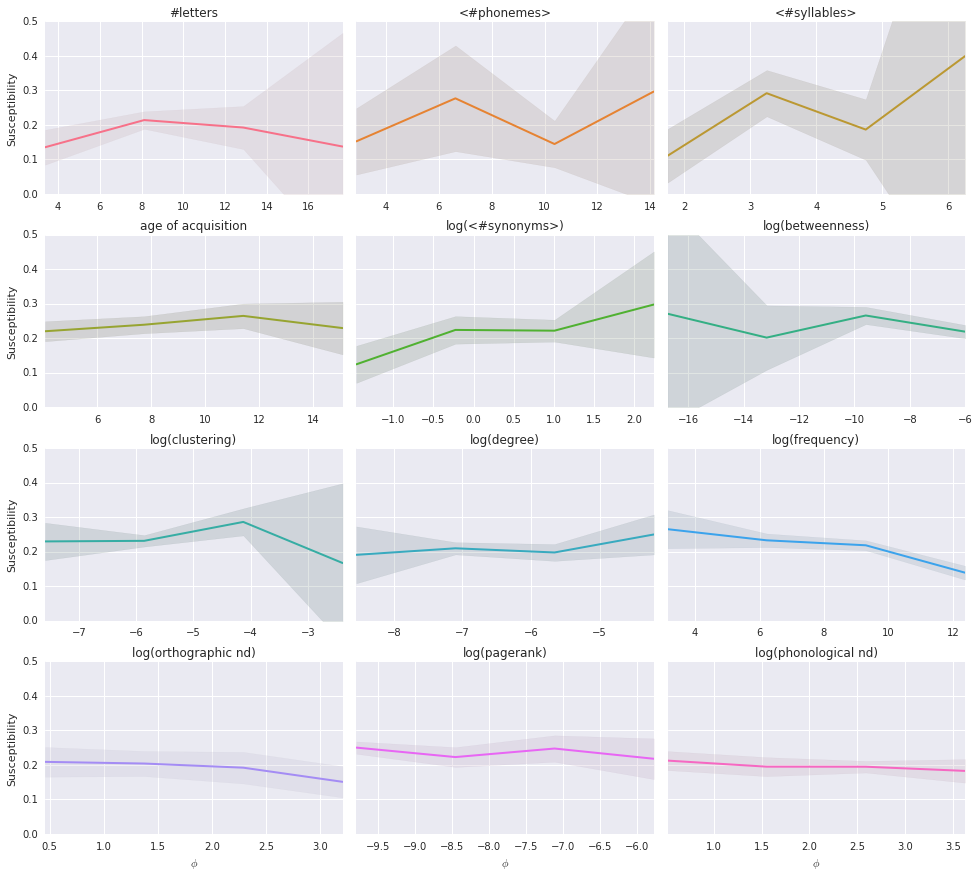

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

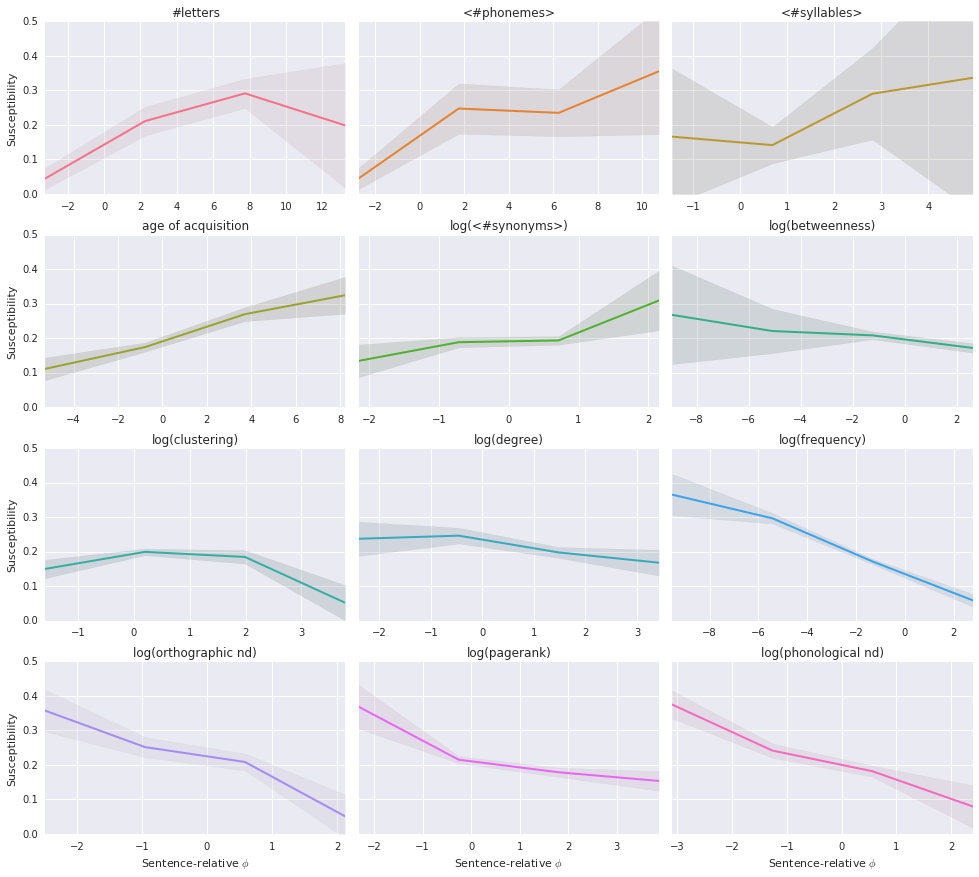

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

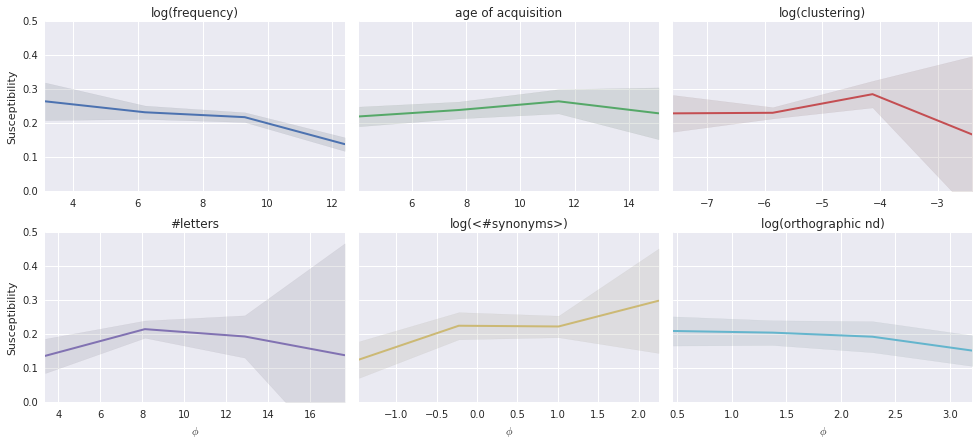

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

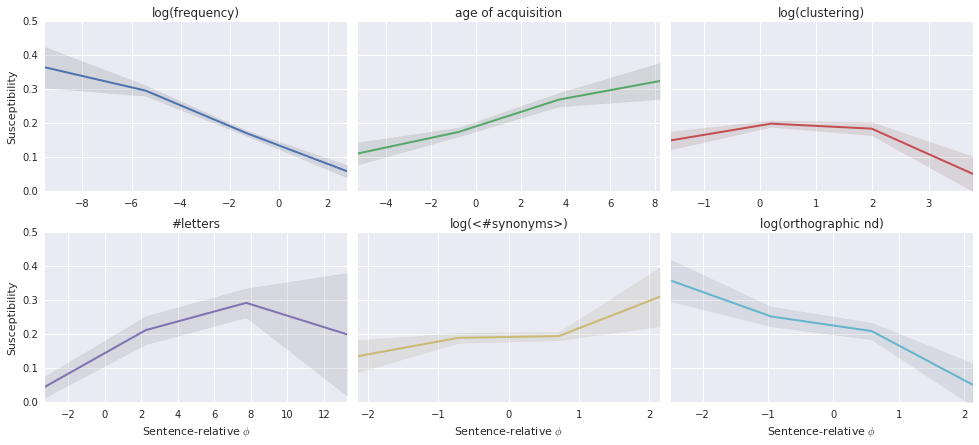

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

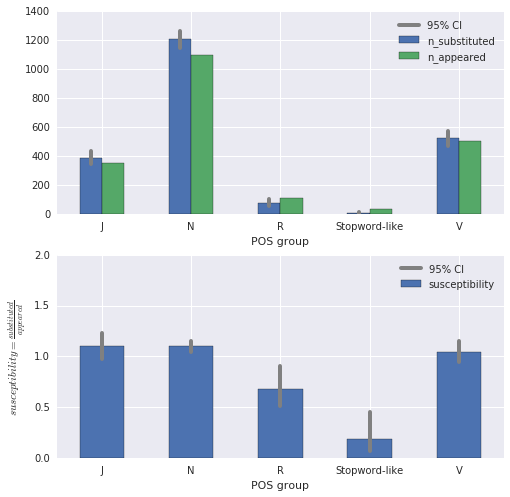

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

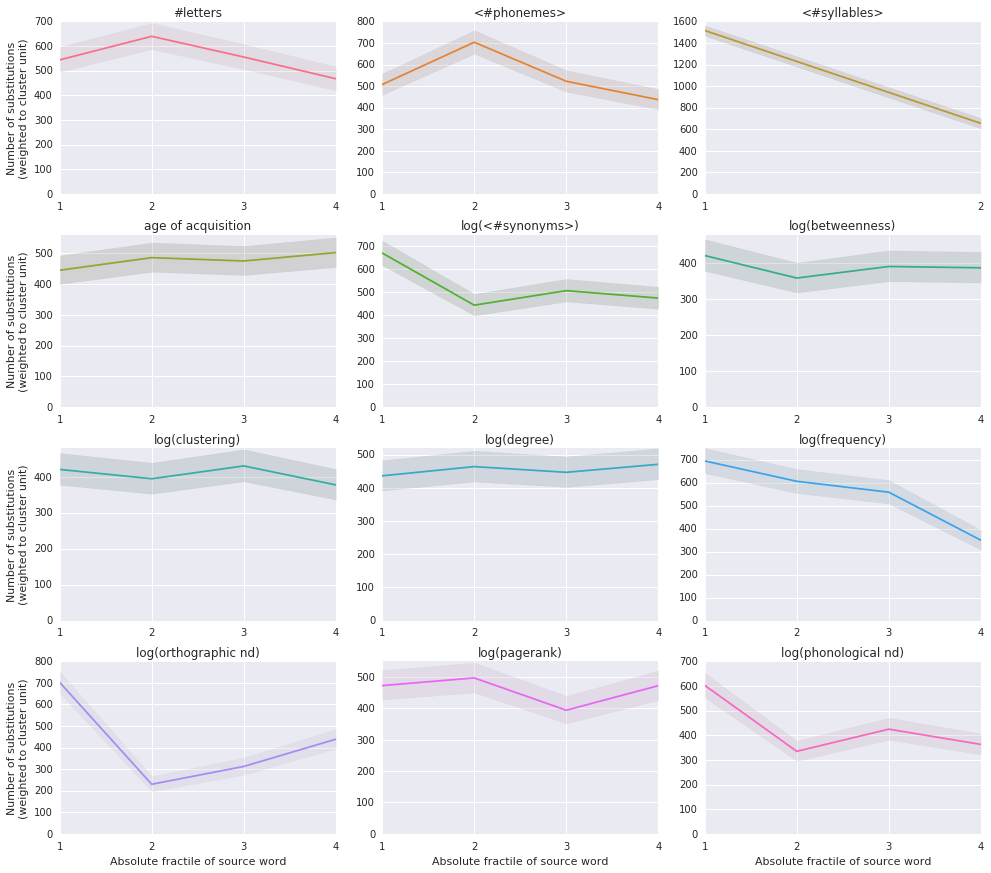

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

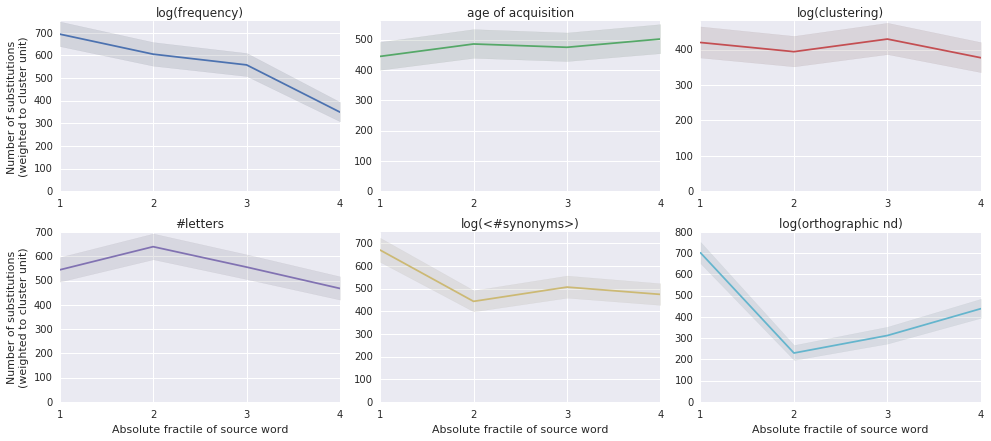

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   63 of 24139) |                    | Elapsed Time: 0:00:01 ETA:  0:06:26

  0% (  144 of 24139) |                    | Elapsed Time: 0:00:02 ETA:  0:04:59

  0% (  226 of 24139) |                    | Elapsed Time: 0:00:03 ETA:  0:04:56

  1% (  302 of 24139) |                    | Elapsed Time: 0:00:04 ETA:  0:05:02

  1% (  383 of 24139) |                    | Elapsed Time: 0:00:05 ETA:  0:04:59

  1% (  472 of 24139) |                    | Elapsed Time: 0:00:06 ETA:  0:04:51

  2% (  562 of 24139) |                    | Elapsed Time: 0:00:07 ETA:  0:04:45

  2% (  604 of 24139) |                    | Elapsed Time: 0:00:07 ETA:  0:04:44

  2% (  689 of 24139) |                    | Elapsed Time: 0:00:08 ETA:  0:04:43

  3% (  783 of 24139) |                    | Elapsed Time: 0:00:09 ETA:  0:04:37

  3% (  844 of 24139) |                    | Elapsed Time: 0:00:10 ETA:  0:04:45

  3% (  906 of 24139) |                    | Elapsed Time: 0:00:11 ETA:  0:04:46

  4% (  980 of 24139) |                    | Elapsed Time: 0:00:12 ETA:  0:04:46

  4% ( 1054 of 24139) |                    | Elapsed Time: 0:00:13 ETA:  0:04:48

  4% ( 1137 of 24139) |                    | Elapsed Time: 0:00:14 ETA:  0:04:50

  5% ( 1207 of 24139) |#                   | Elapsed Time: 0:00:15 ETA:  0:04:58

  5% ( 1304 of 24139) |#                   | Elapsed Time: 0:00:16 ETA:  0:04:49

  5% ( 1373 of 24139) |#                   | Elapsed Time: 0:00:17 ETA:  0:04:55

  5% ( 1442 of 24139) |#                   | Elapsed Time: 0:00:18 ETA:  0:05:06

  6% ( 1509 of 24139) |#                   | Elapsed Time: 0:00:19 ETA:  0:05:07

  6% ( 1582 of 24139) |#                   | Elapsed Time: 0:00:20 ETA:  0:05:07

  6% ( 1682 of 24139) |#                   | Elapsed Time: 0:00:21 ETA:  0:04:52

  7% ( 1759 of 24139) |#                   | Elapsed Time: 0:00:22 ETA:  0:04:54

  7% ( 1811 of 24139) |#                   | Elapsed Time: 0:00:23 ETA:  0:04:48

  7% ( 1914 of 24139) |#                   | Elapsed Time: 0:00:24 ETA:  0:04:44

  8% ( 1995 of 24139) |#                   | Elapsed Time: 0:00:25 ETA:  0:04:36

  8% ( 2058 of 24139) |#                   | Elapsed Time: 0:00:26 ETA:  0:04:38

  8% ( 2113 of 24139) |#                   | Elapsed Time: 0:00:26 ETA:  0:04:22

  9% ( 2186 of 24139) |#                   | Elapsed Time: 0:00:27 ETA:  0:04:24

  9% ( 2273 of 24139) |#                   | Elapsed Time: 0:00:28 ETA:  0:04:18

  9% ( 2357 of 24139) |#                   | Elapsed Time: 0:00:29 ETA:  0:04:24

 10% ( 2414 of 24139) |##                  | Elapsed Time: 0:00:30 ETA:  0:04:22

 10% ( 2484 of 24139) |##                  | Elapsed Time: 0:00:31 ETA:  0:04:27

 10% ( 2563 of 24139) |##                  | Elapsed Time: 0:00:32 ETA:  0:04:37

 10% ( 2631 of 24139) |##                  | Elapsed Time: 0:00:33 ETA:  0:04:43

 11% ( 2716 of 24139) |##                  | Elapsed Time: 0:00:34 ETA:  0:04:31

 11% ( 2790 of 24139) |##                  | Elapsed Time: 0:00:35 ETA:  0:04:37

 11% ( 2866 of 24139) |##                  | Elapsed Time: 0:00:36 ETA:  0:04:35

 12% ( 2945 of 24139) |##                  | Elapsed Time: 0:00:37 ETA:  0:04:37

 12% ( 3018 of 24139) |##                  | Elapsed Time: 0:00:38 ETA:  0:04:38

 12% ( 3099 of 24139) |##                  | Elapsed Time: 0:00:39 ETA:  0:04:35

 13% ( 3175 of 24139) |##                  | Elapsed Time: 0:00:40 ETA:  0:04:31

 13% ( 3254 of 24139) |##                  | Elapsed Time: 0:00:41 ETA:  0:04:30

 13% ( 3320 of 24139) |##                  | Elapsed Time: 0:00:42 ETA:  0:04:25

 14% ( 3398 of 24139) |##                  | Elapsed Time: 0:00:43 ETA:  0:04:27

 14% ( 3475 of 24139) |##                  | Elapsed Time: 0:00:44 ETA:  0:04:25

 14% ( 3555 of 24139) |##                  | Elapsed Time: 0:00:45 ETA:  0:04:22

 15% ( 3621 of 24139) |###                 | Elapsed Time: 0:00:46 ETA:  0:04:19

 15% ( 3707 of 24139) |###                 | Elapsed Time: 0:00:47 ETA:  0:04:16

 15% ( 3787 of 24139) |###                 | Elapsed Time: 0:00:48 ETA:  0:04:15

 15% ( 3861 of 24139) |###                 | Elapsed Time: 0:00:49 ETA:  0:04:15

 16% ( 3923 of 24139) |###                 | Elapsed Time: 0:00:49 ETA:  0:04:14

 16% ( 3996 of 24139) |###                 | Elapsed Time: 0:00:50 ETA:  0:04:15

 16% ( 4075 of 24139) |###                 | Elapsed Time: 0:00:51 ETA:  0:04:14

 17% ( 4151 of 24139) |###                 | Elapsed Time: 0:00:52 ETA:  0:04:13

 17% ( 4225 of 24139) |###                 | Elapsed Time: 0:00:54 ETA:  0:04:20

 17% ( 4306 of 24139) |###                 | Elapsed Time: 0:00:55 ETA:  0:04:22

 18% ( 4387 of 24139) |###                 | Elapsed Time: 0:00:56 ETA:  0:04:20

 18% ( 4461 of 24139) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:19

 18% ( 4527 of 24139) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:15

 19% ( 4602 of 24139) |###                 | Elapsed Time: 0:00:58 ETA:  0:04:13

 19% ( 4678 of 24139) |###                 | Elapsed Time: 0:00:59 ETA:  0:04:13

 19% ( 4771 of 24139) |###                 | Elapsed Time: 0:01:00 ETA:  0:04:04

 20% ( 4828 of 24139) |####                | Elapsed Time: 0:01:01 ETA:  0:03:56

 20% ( 4926 of 24139) |####                | Elapsed Time: 0:01:02 ETA:  0:03:49

 20% ( 5016 of 24139) |####                | Elapsed Time: 0:01:03 ETA:  0:03:44

 21% ( 5092 of 24139) |####                | Elapsed Time: 0:01:04 ETA:  0:03:45

 21% ( 5130 of 24139) |####                | Elapsed Time: 0:01:04 ETA:  0:03:39

 21% ( 5208 of 24139) |####                | Elapsed Time: 0:01:05 ETA:  0:03:43

 21% ( 5298 of 24139) |####                | Elapsed Time: 0:01:06 ETA:  0:03:35

 22% ( 5372 of 24139) |####                | Elapsed Time: 0:01:07 ETA:  0:03:35

 22% ( 5432 of 24139) |####                | Elapsed Time: 0:01:08 ETA:  0:03:39

 22% ( 5529 of 24139) |####                | Elapsed Time: 0:01:09 ETA:  0:03:33

 23% ( 5608 of 24139) |####                | Elapsed Time: 0:01:10 ETA:  0:03:40

 23% ( 5687 of 24139) |####                | Elapsed Time: 0:01:11 ETA:  0:03:44

 23% ( 5734 of 24139) |####                | Elapsed Time: 0:01:12 ETA:  0:03:43

 24% ( 5809 of 24139) |####                | Elapsed Time: 0:01:13 ETA:  0:03:46

 24% ( 5902 of 24139) |####                | Elapsed Time: 0:01:14 ETA:  0:03:39

 24% ( 5977 of 24139) |####                | Elapsed Time: 0:01:15 ETA:  0:03:44

 25% ( 6035 of 24139) |#####               | Elapsed Time: 0:01:16 ETA:  0:03:42

 25% ( 6116 of 24139) |#####               | Elapsed Time: 0:01:17 ETA:  0:03:41

 25% ( 6198 of 24139) |#####               | Elapsed Time: 0:01:18 ETA:  0:03:47

 26% ( 6287 of 24139) |#####               | Elapsed Time: 0:01:19 ETA:  0:03:41

 26% ( 6337 of 24139) |#####               | Elapsed Time: 0:01:19 ETA:  0:03:39

 26% ( 6414 of 24139) |#####               | Elapsed Time: 0:01:20 ETA:  0:03:37

 26% ( 6494 of 24139) |#####               | Elapsed Time: 0:01:21 ETA:  0:03:34

 27% ( 6569 of 24139) |#####               | Elapsed Time: 0:01:22 ETA:  0:03:41

 27% ( 6639 of 24139) |#####               | Elapsed Time: 0:01:23 ETA:  0:03:36

 27% ( 6726 of 24139) |#####               | Elapsed Time: 0:01:24 ETA:  0:03:31

 28% ( 6780 of 24139) |#####               | Elapsed Time: 0:01:26 ETA:  0:04:22

 28% ( 6868 of 24139) |#####               | Elapsed Time: 0:01:27 ETA:  0:04:17

 28% ( 6940 of 24139) |#####               | Elapsed Time: 0:01:28 ETA:  0:04:24

 29% ( 7023 of 24139) |#####               | Elapsed Time: 0:01:29 ETA:  0:04:21

 29% ( 7107 of 24139) |#####               | Elapsed Time: 0:01:30 ETA:  0:04:16

 29% ( 7188 of 24139) |#####               | Elapsed Time: 0:01:31 ETA:  0:04:15

 30% ( 7242 of 24139) |######              | Elapsed Time: 0:01:32 ETA:  0:04:11

 30% ( 7309 of 24139) |######              | Elapsed Time: 0:01:33 ETA:  0:04:17

 30% ( 7393 of 24139) |######              | Elapsed Time: 0:01:34 ETA:  0:04:18

 30% ( 7475 of 24139) |######              | Elapsed Time: 0:01:35 ETA:  0:03:23

 31% ( 7544 of 24139) |######              | Elapsed Time: 0:01:36 ETA:  0:03:26

 31% ( 7630 of 24139) |######              | Elapsed Time: 0:01:37 ETA:  0:03:20

 31% ( 7707 of 24139) |######              | Elapsed Time: 0:01:38 ETA:  0:03:21

 32% ( 7787 of 24139) |######              | Elapsed Time: 0:01:39 ETA:  0:03:22

 32% ( 7846 of 24139) |######              | Elapsed Time: 0:01:39 ETA:  0:03:21

 32% ( 7940 of 24139) |######              | Elapsed Time: 0:01:40 ETA:  0:03:16

 33% ( 8021 of 24139) |######              | Elapsed Time: 0:01:41 ETA:  0:03:09

 33% ( 8098 of 24139) |######              | Elapsed Time: 0:01:42 ETA:  0:03:11

 33% ( 8147 of 24139) |######              | Elapsed Time: 0:01:43 ETA:  0:03:09

 34% ( 8241 of 24139) |######              | Elapsed Time: 0:01:44 ETA:  0:03:03

 34% ( 8319 of 24139) |######              | Elapsed Time: 0:01:45 ETA:  0:03:06

 34% ( 8413 of 24139) |######              | Elapsed Time: 0:01:46 ETA:  0:02:58

 35% ( 8449 of 24139) |#######             | Elapsed Time: 0:01:47 ETA:  0:02:54

 35% ( 8527 of 24139) |#######             | Elapsed Time: 0:01:48 ETA:  0:02:57

 35% ( 8603 of 24139) |#######             | Elapsed Time: 0:01:49 ETA:  0:03:03

 36% ( 8697 of 24139) |#######             | Elapsed Time: 0:01:50 ETA:  0:02:57

 36% ( 8751 of 24139) |#######             | Elapsed Time: 0:01:50 ETA:  0:02:51

 36% ( 8830 of 24139) |#######             | Elapsed Time: 0:01:51 ETA:  0:02:54

 36% ( 8908 of 24139) |#######             | Elapsed Time: 0:01:52 ETA:  0:03:00

 37% ( 8994 of 24139) |#######             | Elapsed Time: 0:01:53 ETA:  0:02:55

 37% ( 9053 of 24139) |#######             | Elapsed Time: 0:01:54 ETA:  0:02:59

 37% ( 9139 of 24139) |#######             | Elapsed Time: 0:01:55 ETA:  0:02:57

 38% ( 9239 of 24139) |#######             | Elapsed Time: 0:01:56 ETA:  0:02:47

 38% ( 9322 of 24139) |#######             | Elapsed Time: 0:01:57 ETA:  0:02:43

 38% ( 9354 of 24139) |#######             | Elapsed Time: 0:01:57 ETA:  0:02:48

 39% ( 9440 of 24139) |#######             | Elapsed Time: 0:01:58 ETA:  0:02:47

 39% ( 9527 of 24139) |#######             | Elapsed Time: 0:01:59 ETA:  0:02:42

 39% ( 9624 of 24139) |#######             | Elapsed Time: 0:02:00 ETA:  0:02:34

 40% ( 9656 of 24139) |########            | Elapsed Time: 0:02:01 ETA:  0:02:32

 40% ( 9738 of 24139) |########            | Elapsed Time: 0:02:02 ETA:  0:02:32

 40% ( 9825 of 24139) |########            | Elapsed Time: 0:02:03 ETA:  0:02:31

 41% ( 9914 of 24139) |########            | Elapsed Time: 0:02:04 ETA:  0:02:34

 41% ( 9958 of 24139) |########            | Elapsed Time: 0:02:04 ETA:  0:02:28

 41% (10047 of 24139) |########            | Elapsed Time: 0:02:05 ETA:  0:02:25

 41% (10134 of 24139) |########            | Elapsed Time: 0:02:06 ETA:  0:02:23

 42% (10215 of 24139) |########            | Elapsed Time: 0:02:07 ETA:  0:02:25

 42% (10260 of 24139) |########            | Elapsed Time: 0:02:08 ETA:  0:02:31

 42% (10345 of 24139) |########            | Elapsed Time: 0:02:09 ETA:  0:02:32

 43% (10428 of 24139) |########            | Elapsed Time: 0:02:10 ETA:  0:02:31

 43% (10515 of 24139) |########            | Elapsed Time: 0:02:11 ETA:  0:02:29

 43% (10561 of 24139) |########            | Elapsed Time: 0:02:11 ETA:  0:02:34

 44% (10635 of 24139) |########            | Elapsed Time: 0:02:12 ETA:  0:02:42

 44% (10710 of 24139) |########            | Elapsed Time: 0:02:13 ETA:  0:02:47

 44% (10795 of 24139) |########            | Elapsed Time: 0:02:14 ETA:  0:02:47

 45% (10863 of 24139) |#########           | Elapsed Time: 0:02:15 ETA:  0:02:44

 45% (10950 of 24139) |#########           | Elapsed Time: 0:02:16 ETA:  0:02:39

 45% (11022 of 24139) |#########           | Elapsed Time: 0:02:17 ETA:  0:02:43

 45% (11096 of 24139) |#########           | Elapsed Time: 0:02:18 ETA:  0:02:46

 46% (11165 of 24139) |#########           | Elapsed Time: 0:02:19 ETA:  0:02:50

 46% (11239 of 24139) |#########           | Elapsed Time: 0:02:20 ETA:  0:02:49

 46% (11325 of 24139) |#########           | Elapsed Time: 0:02:21 ETA:  0:02:43

 47% (11404 of 24139) |#########           | Elapsed Time: 0:02:22 ETA:  0:02:40

 47% (11467 of 24139) |#########           | Elapsed Time: 0:02:23 ETA:  0:02:39

 47% (11545 of 24139) |#########           | Elapsed Time: 0:02:24 ETA:  0:02:43

 48% (11628 of 24139) |#########           | Elapsed Time: 0:02:25 ETA:  0:02:44

 48% (11722 of 24139) |#########           | Elapsed Time: 0:02:26 ETA:  0:02:33

 48% (11768 of 24139) |#########           | Elapsed Time: 0:02:26 ETA:  0:02:28

 49% (11847 of 24139) |#########           | Elapsed Time: 0:02:27 ETA:  0:02:26

 49% (11924 of 24139) |#########           | Elapsed Time: 0:02:28 ETA:  0:02:24

 49% (12014 of 24139) |#########           | Elapsed Time: 0:02:29 ETA:  0:02:21

 50% (12070 of 24139) |##########          | Elapsed Time: 0:02:30 ETA:  0:02:18

 50% (12161 of 24139) |##########          | Elapsed Time: 0:02:31 ETA:  0:02:15

 50% (12250 of 24139) |##########          | Elapsed Time: 0:02:32 ETA:  0:02:09

 51% (12330 of 24139) |##########          | Elapsed Time: 0:02:33 ETA:  0:02:09

 51% (12372 of 24139) |##########          | Elapsed Time: 0:02:34 ETA:  0:02:10

 51% (12458 of 24139) |##########          | Elapsed Time: 0:02:35 ETA:  0:02:10

 51% (12546 of 24139) |##########          | Elapsed Time: 0:02:36 ETA:  0:02:05

 52% (12633 of 24139) |##########          | Elapsed Time: 0:02:37 ETA:  0:02:00

 52% (12673 of 24139) |##########          | Elapsed Time: 0:02:37 ETA:  0:01:59

 52% (12759 of 24139) |##########          | Elapsed Time: 0:02:38 ETA:  0:01:58

 53% (12836 of 24139) |##########          | Elapsed Time: 0:02:39 ETA:  0:02:03

 53% (12912 of 24139) |##########          | Elapsed Time: 0:02:40 ETA:  0:02:07

 53% (12975 of 24139) |##########          | Elapsed Time: 0:02:41 ETA:  0:02:07

 54% (13059 of 24139) |##########          | Elapsed Time: 0:02:42 ETA:  0:02:08

 54% (13144 of 24139) |##########          | Elapsed Time: 0:02:43 ETA:  0:02:07

 54% (13228 of 24139) |##########          | Elapsed Time: 0:02:44 ETA:  0:02:08

 55% (13277 of 24139) |###########         | Elapsed Time: 0:02:44 ETA:  0:02:04

 55% (13364 of 24139) |###########         | Elapsed Time: 0:02:45 ETA:  0:02:04

 55% (13444 of 24139) |###########         | Elapsed Time: 0:02:46 ETA:  0:02:05

 56% (13530 of 24139) |###########         | Elapsed Time: 0:02:47 ETA:  0:02:00

 56% (13579 of 24139) |###########         | Elapsed Time: 0:02:48 ETA:  0:01:58

 56% (13668 of 24139) |###########         | Elapsed Time: 0:02:49 ETA:  0:01:53

 57% (13761 of 24139) |###########         | Elapsed Time: 0:02:50 ETA:  0:01:48

 57% (13848 of 24139) |###########         | Elapsed Time: 0:02:51 ETA:  0:01:47

 57% (13880 of 24139) |###########         | Elapsed Time: 0:02:51 ETA:  0:01:44

 57% (13974 of 24139) |###########         | Elapsed Time: 0:02:52 ETA:  0:01:44

 58% (14060 of 24139) |###########         | Elapsed Time: 0:02:53 ETA:  0:01:43

 58% (14142 of 24139) |###########         | Elapsed Time: 0:02:54 ETA:  0:01:41

 58% (14182 of 24139) |###########         | Elapsed Time: 0:02:55 ETA:  0:01:42

 59% (14263 of 24139) |###########         | Elapsed Time: 0:02:56 ETA:  0:01:42

 59% (14337 of 24139) |###########         | Elapsed Time: 0:02:57 ETA:  0:01:47

 59% (14417 of 24139) |###########         | Elapsed Time: 0:02:58 ETA:  0:01:52

 60% (14484 of 24139) |############        | Elapsed Time: 0:02:59 ETA:  0:01:53

 60% (14585 of 24139) |############        | Elapsed Time: 0:03:00 ETA:  0:01:47

 60% (14675 of 24139) |############        | Elapsed Time: 0:03:01 ETA:  0:01:48

 61% (14786 of 24139) |############        | Elapsed Time: 0:03:02 ETA:  0:01:41

 61% (14872 of 24139) |############        | Elapsed Time: 0:03:03 ETA:  0:01:38

 61% (14960 of 24139) |############        | Elapsed Time: 0:03:04 ETA:  0:01:34

 62% (15045 of 24139) |############        | Elapsed Time: 0:03:05 ETA:  0:01:29

 62% (15087 of 24139) |############        | Elapsed Time: 0:03:05 ETA:  0:01:28

 62% (15166 of 24139) |############        | Elapsed Time: 0:03:06 ETA:  0:01:29

 63% (15250 of 24139) |############        | Elapsed Time: 0:03:07 ETA:  0:01:34

 63% (15341 of 24139) |############        | Elapsed Time: 0:03:08 ETA:  0:01:33

 63% (15389 of 24139) |############        | Elapsed Time: 0:03:09 ETA:  0:01:35

 64% (15476 of 24139) |############        | Elapsed Time: 0:03:10 ETA:  0:01:36

 64% (15564 of 24139) |############        | Elapsed Time: 0:03:11 ETA:  0:01:34

 64% (15655 of 24139) |############        | Elapsed Time: 0:03:12 ETA:  0:01:32

 65% (15691 of 24139) |#############       | Elapsed Time: 0:03:12 ETA:  0:01:30

 65% (15790 of 24139) |#############       | Elapsed Time: 0:03:13 ETA:  0:01:21

 65% (15876 of 24139) |#############       | Elapsed Time: 0:03:14 ETA:  0:01:18

 66% (15941 of 24139) |#############       | Elapsed Time: 0:03:15 ETA:  0:01:25

 66% (15993 of 24139) |#############       | Elapsed Time: 0:03:16 ETA:  0:01:26

 66% (16076 of 24139) |#############       | Elapsed Time: 0:03:17 ETA:  0:01:25

 66% (16165 of 24139) |#############       | Elapsed Time: 0:03:18 ETA:  0:01:24

 67% (16253 of 24139) |#############       | Elapsed Time: 0:03:19 ETA:  0:01:22

 67% (16294 of 24139) |#############       | Elapsed Time: 0:03:20 ETA:  0:01:22

 67% (16389 of 24139) |#############       | Elapsed Time: 0:03:21 ETA:  0:01:18

 68% (16480 of 24139) |#############       | Elapsed Time: 0:03:22 ETA:  0:01:20

 68% (16557 of 24139) |#############       | Elapsed Time: 0:03:24 ETA:  0:02:23

 68% (16596 of 24139) |#############       | Elapsed Time: 0:03:25 ETA:  0:02:18

 69% (16676 of 24139) |#############       | Elapsed Time: 0:03:26 ETA:  0:02:17

 69% (16754 of 24139) |#############       | Elapsed Time: 0:03:27 ETA:  0:02:18

 69% (16830 of 24139) |#############       | Elapsed Time: 0:03:28 ETA:  0:02:24

 70% (16898 of 24139) |##############      | Elapsed Time: 0:03:29 ETA:  0:02:26

 70% (16982 of 24139) |##############      | Elapsed Time: 0:03:30 ETA:  0:02:23

 70% (17069 of 24139) |##############      | Elapsed Time: 0:03:31 ETA:  0:02:26

 71% (17156 of 24139) |##############      | Elapsed Time: 0:03:32 ETA:  0:02:27

 71% (17200 of 24139) |##############      | Elapsed Time: 0:03:32 ETA:  0:01:22

 71% (17273 of 24139) |##############      | Elapsed Time: 0:03:33 ETA:  0:01:24

 71% (17347 of 24139) |##############      | Elapsed Time: 0:03:34 ETA:  0:01:26

 72% (17428 of 24139) |##############      | Elapsed Time: 0:03:35 ETA:  0:01:23

 72% (17501 of 24139) |##############      | Elapsed Time: 0:03:36 ETA:  0:01:19

 72% (17588 of 24139) |##############      | Elapsed Time: 0:03:37 ETA:  0:01:17

 73% (17662 of 24139) |##############      | Elapsed Time: 0:03:38 ETA:  0:01:21

 73% (17758 of 24139) |##############      | Elapsed Time: 0:03:39 ETA:  0:01:16

 73% (17803 of 24139) |##############      | Elapsed Time: 0:03:40 ETA:  0:01:17

 74% (17900 of 24139) |##############      | Elapsed Time: 0:03:41 ETA:  0:01:10

 74% (17992 of 24139) |##############      | Elapsed Time: 0:03:42 ETA:  0:01:01

 74% (18076 of 24139) |##############      | Elapsed Time: 0:03:43 ETA:  0:00:56

 75% (18105 of 24139) |###############     | Elapsed Time: 0:03:43 ETA:  0:00:53

 75% (18195 of 24139) |###############     | Elapsed Time: 0:03:44 ETA:  0:00:50

 75% (18280 of 24139) |###############     | Elapsed Time: 0:03:45 ETA:  0:00:49

 76% (18369 of 24139) |###############     | Elapsed Time: 0:03:46 ETA:  0:00:42

 76% (18406 of 24139) |###############     | Elapsed Time: 0:03:46 ETA:  0:00:44

 76% (18482 of 24139) |###############     | Elapsed Time: 0:03:47 ETA:  0:00:47

 76% (18567 of 24139) |###############     | Elapsed Time: 0:03:48 ETA:  0:00:51

 77% (18655 of 24139) |###############     | Elapsed Time: 0:03:49 ETA:  0:00:52

 77% (18708 of 24139) |###############     | Elapsed Time: 0:03:50 ETA:  0:00:49

 77% (18800 of 24139) |###############     | Elapsed Time: 0:03:51 ETA:  0:00:46

 78% (18876 of 24139) |###############     | Elapsed Time: 0:03:52 ETA:  0:00:51

 78% (18962 of 24139) |###############     | Elapsed Time: 0:03:53 ETA:  0:00:49

 78% (19010 of 24139) |###############     | Elapsed Time: 0:03:53 ETA:  0:00:49

 79% (19100 of 24139) |###############     | Elapsed Time: 0:03:54 ETA:  0:00:47

 79% (19183 of 24139) |###############     | Elapsed Time: 0:03:55 ETA:  0:00:43

 79% (19266 of 24139) |###############     | Elapsed Time: 0:03:56 ETA:  0:00:43

 80% (19312 of 24139) |################    | Elapsed Time: 0:03:57 ETA:  0:00:41

 80% (19388 of 24139) |################    | Elapsed Time: 0:03:58 ETA:  0:00:46

 80% (19468 of 24139) |################    | Elapsed Time: 0:03:59 ETA:  0:00:50

 81% (19554 of 24139) |################    | Elapsed Time: 0:04:00 ETA:  0:00:45

 81% (19613 of 24139) |################    | Elapsed Time: 0:04:01 ETA:  0:00:46

 81% (19707 of 24139) |################    | Elapsed Time: 0:04:02 ETA:  0:00:43

 81% (19785 of 24139) |################    | Elapsed Time: 0:04:03 ETA:  0:00:47

 82% (19870 of 24139) |################    | Elapsed Time: 0:04:04 ETA:  0:00:45

 82% (19915 of 24139) |################    | Elapsed Time: 0:04:04 ETA:  0:00:41

 82% (19999 of 24139) |################    | Elapsed Time: 0:04:05 ETA:  0:00:43

 83% (20089 of 24139) |################    | Elapsed Time: 0:04:06 ETA:  0:00:36

 83% (20176 of 24139) |################    | Elapsed Time: 0:04:07 ETA:  0:00:33

 83% (20217 of 24139) |################    | Elapsed Time: 0:04:08 ETA:  0:00:31

 84% (20311 of 24139) |################    | Elapsed Time: 0:04:09 ETA:  0:00:25

 84% (20402 of 24139) |################    | Elapsed Time: 0:04:10 ETA:  0:00:25

 84% (20496 of 24139) |################    | Elapsed Time: 0:04:11 ETA:  0:00:17

 85% (20519 of 24139) |#################   | Elapsed Time: 0:04:11 ETA:  0:00:16

 85% (20605 of 24139) |#################   | Elapsed Time: 0:04:12 ETA:  0:00:18

 85% (20699 of 24139) |#################   | Elapsed Time: 0:04:13 ETA:  0:00:13

 86% (20783 of 24139) |#################   | Elapsed Time: 0:04:14 ETA:  0:00:14

 86% (20820 of 24139) |#################   | Elapsed Time: 0:04:14 ETA:  0:00:13

 86% (20905 of 24139) |#################   | Elapsed Time: 0:04:15 ETA:  0:00:15

 86% (20990 of 24139) |#################   | Elapsed Time: 0:04:16 ETA:  0:00:18

 87% (21072 of 24139) |#################   | Elapsed Time: 0:04:17 ETA:  0:00:21

 87% (21122 of 24139) |#################   | Elapsed Time: 0:04:18 ETA:  0:00:25

 87% (21210 of 24139) |#################   | Elapsed Time: 0:04:19 ETA:  0:00:23

 88% (21294 of 24139) |#################   | Elapsed Time: 0:04:20 ETA:  0:00:24

 88% (21379 of 24139) |#################   | Elapsed Time: 0:04:21 ETA:  0:00:27

 88% (21424 of 24139) |#################   | Elapsed Time: 0:04:22 ETA:  0:00:26

 89% (21503 of 24139) |#################   | Elapsed Time: 0:04:23 ETA:  0:00:27

 89% (21589 of 24139) |#################   | Elapsed Time: 0:04:24 ETA:  0:00:26

 89% (21671 of 24139) |#################   | Elapsed Time: 0:04:25 ETA:  0:00:26

 90% (21726 of 24139) |##################  | Elapsed Time: 0:04:25 ETA:  0:00:24

 90% (21816 of 24139) |##################  | Elapsed Time: 0:04:26 ETA:  0:00:19

 90% (21892 of 24139) |##################  | Elapsed Time: 0:04:27 ETA:  0:00:23

 91% (21971 of 24139) |##################  | Elapsed Time: 0:04:28 ETA:  0:00:24

 91% (22027 of 24139) |##################  | Elapsed Time: 0:04:29 ETA:  0:00:25

 91% (22116 of 24139) |##################  | Elapsed Time: 0:04:30 ETA:  0:00:21

 91% (22206 of 24139) |##################  | Elapsed Time: 0:04:31 ETA:  0:00:15

 92% (22287 of 24139) |##################  | Elapsed Time: 0:04:32 ETA:  0:00:16

 92% (22329 of 24139) |##################  | Elapsed Time: 0:04:32 ETA:  0:00:13

 92% (22416 of 24139) |##################  | Elapsed Time: 0:04:33 ETA:  0:00:11

 93% (22499 of 24139) |##################  | Elapsed Time: 0:04:34 ETA:  0:00:13

 93% (22584 of 24139) |##################  | Elapsed Time: 0:04:35 ETA:  0:00:09

 93% (22631 of 24139) |##################  | Elapsed Time: 0:04:36 ETA:  0:00:07

 94% (22712 of 24139) |##################  | Elapsed Time: 0:04:37 ETA:  0:00:07

 94% (22800 of 24139) |##################  | Elapsed Time: 0:04:38 ETA:  0:00:07

 94% (22875 of 24139) |##################  | Elapsed Time: 0:04:39 ETA:  0:00:12

 95% (22933 of 24139) |################### | Elapsed Time: 0:04:40 ETA:  0:00:07

 95% (23016 of 24139) |################### | Elapsed Time: 0:04:41 ETA:  0:00:09

 95% (23099 of 24139) |################### | Elapsed Time: 0:04:42 ETA:  0:00:09

 96% (23188 of 24139) |################### | Elapsed Time: 0:04:43 ETA:  0:00:06

 96% (23234 of 24139) |################### | Elapsed Time: 0:04:43 ETA:  0:00:05

 96% (23319 of 24139) |################### | Elapsed Time: 0:04:44 ETA:  0:00:03

 96% (23408 of 24139) |################### | Elapsed Time: 0:04:45 ETA:  0:00:00

 97% (23480 of 24139) |################### | Elapsed Time: 0:04:46 ETA:  0:00:04

 97% (23536 of 24139) |################### | Elapsed Time: 0:04:47 ETA:  0:00:00

 97% (23622 of 24139) |################### | Elapsed Time: 0:04:48 ETA:  0:00:01

 98% (23711 of 24139) |################### | Elapsed Time: 0:04:49 ETA:  0:00:00

 98% (23802 of 24139) |################### | Elapsed Time: 0:04:50 ETA:  0:00:00

 98% (23838 of 24139) |################### | Elapsed Time: 0:04:50 ETA:  0:00:00

 99% (23925 of 24139) |################### | Elapsed Time: 0:04:51 ETA:  0:00:00

 99% (24015 of 24139) |################### | Elapsed Time: 0:04:52 ETA:  0:00:00

 99% (24089 of 24139) |################### | Elapsed Time: 0:04:53 ETA:  0:00:00

100% (24139 of 24139) |####################| Elapsed Time: 0:04:54 Time: 0:04:54


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

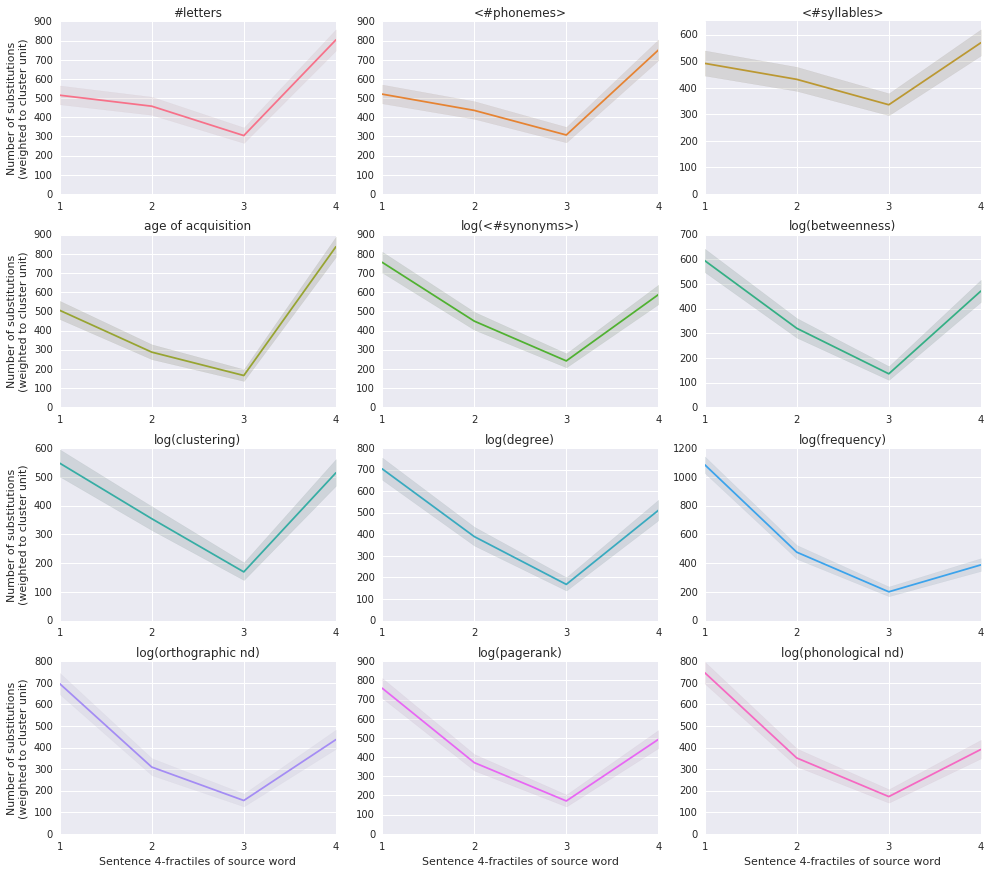

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

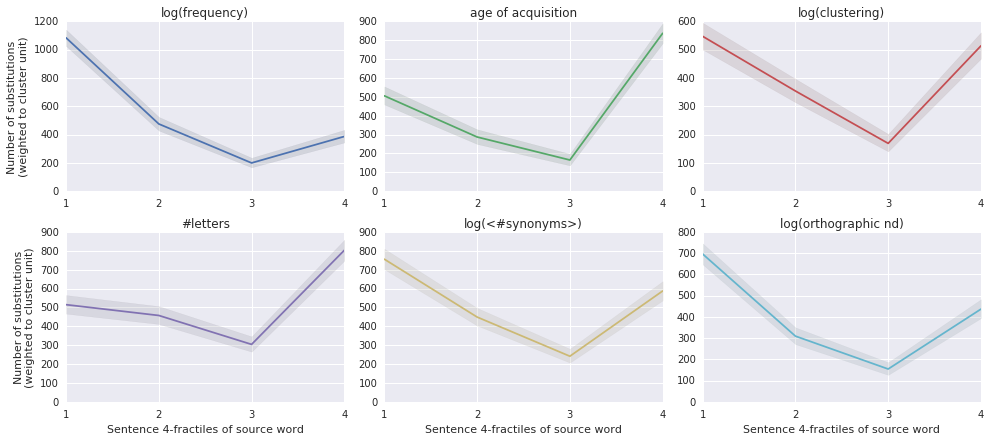

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)